In [10]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *

In [11]:
df = pd.read_csv('results/gemma2_split.csv')

NEUTRALS = [
'giornaista',
'autista',
'dentista',
'ginnasta',
'consulente',
'estetista',
'farmacista',
'contabile',
'nutrizionista',
'giardiniere',
'insegnante',
'igienista dentale',]

df['text_JOB_value'] = df.apply(lambda x: x['text_JOB_value'] if isinstance(x['text_JOB_value'],str) else "", axis=1)
df = df[~df['text_JOB_value'].isin(NEUTRALS)]
df = df[~df['text_JOB_value'].str.contains("Ã")]
df = df[~df['text_JOB_value'].str.contains(' o ')]
df = df[~df['text_JOB_value'].str.contains(' e ')]

df['true'] = df.apply(lambda x: ('INCLUSIVO' if x['text_JOB_label'] == 'neutro' else 'NON INCLUSIVO') if x['text_labels'] == 'TODO' else x['text_labels'], axis=1)
LABELS = ['INCLUSIVO', 'NON INCLUSIVO']
def fix_gemma2(df):
    fdf = df.copy()
    def _f(x):
        r = x['response'].upper()
        if 'NON INCLUSIVO' in r:
            return 'NON INCLUSIVO'
        return 'INCLUSIVO'
    fdf['response'] = fdf.apply(lambda x: _f(x), axis=1)
    return fdf
df_fix = fix_gemma2(df)
df_fix

,prompt_id,text_id,text_labels,response,text_JOB_value,text_JOB_label,true
12,zsl#0,t#0_JOB#12,TODO,NON INCLUSIVO,infermiere,maschile,NON INCLUSIVO
13,zsl#0,t#0_JOB#13,TODO,NON INCLUSIVO,infermiera,femminile,NON INCLUSIVO
14,zsl#0,t#0_JOB#14,TODO,INCLUSIVO,infermier*,neutro,INCLUSIVO
15,zsl#0,t#0_JOB#15,TODO,INCLUSIVO,infermiere/a,neutro,INCLUSIVO
17,zsl#0,t#0_JOB#17,TODO,INCLUSIVO,infermiera/e,neutro,INCLUSIVO
...,...,...,...,...,...,...,...
566,zsl#0,t#29_JOB#132,TODO,NON INCLUSIVO,traduttore/traduttrice,neutro,INCLUSIVO
567,zsl#0,t#29_JOB#133,TODO,NON INCLUSIVO,traduttrice/traduttore,neutro,INCLUSIVO
570,zsl#0,t#30,INCLUSIVO,INCLUSIVO,,NaN,INCLUSIVO
571,zsl#0,t#31,INCLUSIVO,INCLUSIVO,,NaN,INCLUSIVO


In [12]:
print(df_fix['true'].value_counts())
print(df_fix['response'].value_counts())

true
INCLUSIVO        197
NON INCLUSIVO    152
Name: count, dtype: int64
response
NON INCLUSIVO    206
INCLUSIVO        143
Name: count, dtype: int64


In [13]:
true_positives = df_fix[(df_fix['true'] == 'INCLUSIVO') & (df_fix['response'] == 'INCLUSIVO')]
true_negatives = df_fix[(df_fix['true'] == 'NON INCLUSIVO') & (df_fix['response'] == 'NON INCLUSIVO')]
false_positives = df_fix[(df_fix['true'] == 'NON INCLUSIVO') & (df_fix['response'] == 'INCLUSIVO')]
false_negatives = df_fix[(df_fix['true'] == 'INCLUSIVO') & (df_fix['response'] == 'NON INCLUSIVO')]
print(f"TP: {len(true_positives)}")
print(f"TN: {len(true_negatives)}")
print(f"FP: {len(false_positives)}")
print(f"FN: {len(false_negatives)}")
sensitivity = len(true_positives) / (len(true_positives) + len(false_negatives))
specificity = len(true_negatives) / (len(true_negatives) + len(false_positives))
accuracy = (len(true_positives) + len(true_negatives)) / len(df_fix)
precision = len(true_positives) / (len(true_positives) + len(false_positives))
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
negative_predictive_value = len(true_negatives) / (len(true_negatives) + len(false_negatives))
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1: {f1}")
print(f"Negative Predictive Value: {negative_predictive_value}")

TP: 131
TN: 140
FP: 12
FN: 66
Sensitivity: 0.6649746192893401
Specificity: 0.9210526315789473
Accuracy: 0.7765042979942693
Precision: 0.916083916083916
F1: 0.7705882352941177
Negative Predictive Value: 0.6796116504854369


               precision    recall  f1-score   support

    INCLUSIVO       0.92      0.66      0.77       197
NON INCLUSIVO       0.68      0.92      0.78       152

     accuracy                           0.78       349
    macro avg       0.80      0.79      0.78       349
 weighted avg       0.81      0.78      0.78       349



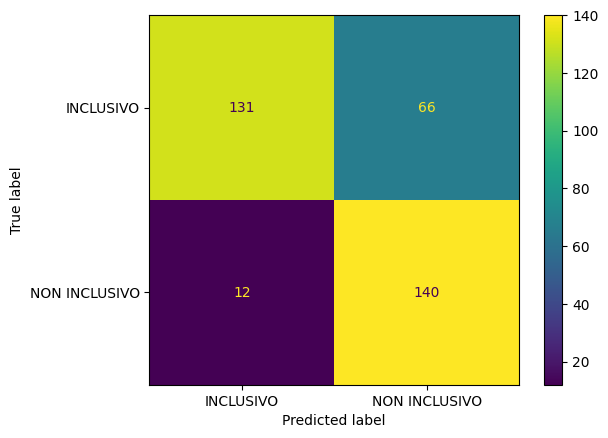

In [14]:
cm = skm.confusion_matrix(df_fix['true'], df_fix['response'])
disp = skm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot()
print(skm.classification_report(df_fix['true'], df_fix['response'], target_names=LABELS))